# Часть 1. Загрузка библиотек и изучение данных из предоставленных файлов.

## Загрузка библиотек и вывод общей информации о таблице

In [1]:
#импортирует библиотеку
import pandas as pd 
import numpy as np
import re
import seaborn  as sns
import matplotlib.pyplot as plt
from scipy import stats as st

#включаем отображение всех столбцов
pd.set_option('display.max_columns', None) 
#загружаем файл с данными

DATA_SET_LOCAL_PATH = './datasets/'
DATA_SET_YP_PATH = '/datasets/'


def get_data(file_name):
    """
    Функция для загрузки данных из файла и ввода информации об этих данных
    Функция возвращает pdndas.DataFrame с данными загруженными из файла
    """    
    try:
        data = pd.read_csv(DATA_SET_LOCAL_PATH+file_name)
    except:
        data = pd.read_csv(DATA_SET_YP_PATH+file_name)
    return data


games_history = get_data('games.csv')   

In [2]:
def info_print (data,title,column='',bins=20,unit='',prntInfo=True,prntGraph=True,returnMetric=False):
    if prntInfo:
        div = ''.join(['=' for i in range(1,len(title))])
        print(div)
        print('\n',title,'\n')
        print(div)
        data.info()
        print(div)
        print(f'Количество дубликатов: {data.duplicated().sum()}')
        print(div)
        if data.duplicated().sum() > 0:
            print(f'Пример дубликатов:')
            display(data.loc[data.duplicated(keep=False)].head())            
            print(div)
        print(f'Пример первых 5 записей:')
        display(data.head())             
        print(div)
     
    if column != '':
        data_prin = data[column]
    else:
        data_prin = data
        
    if prntGraph:
        try:
            std_dev = np.std(data_prin) #Стандартное распределение
            mu = data_prin.mean() #среднее значение 
            sigma3_min = mu - 3*std_dev
            sigma3_max = mu + 3*std_dev
            print(f'Среднее: {round(mu,2)} \n')
            print(f'Стандартное отклонение: {round(std_dev,2)} \n')
            print(f'Доверительный интервал: от {round(sigma3_min,2)} до {round(sigma3_max,2)} \n')    
            fig, ax = plt.subplots(1,2,figsize=(17, 3))
            fig.suptitle(title) 
            sns.boxplot(x=data_prin, ax=ax[0])
         
            sns.histplot(x=data_prin, ax=ax[1],bins=bins)              
            #границы по правилам трёх сигм
            plt.axvline(sigma3_min,color='r',linestyle='--') 
            plt.axvline(sigma3_max,color='r',linestyle='--')
            ax[0].set_xlabel(unit, fontsize=15, color='black')            
            ax[1].set_xlabel(unit, fontsize=15, color='black')
            plt.show()      
            if returnMetric: return mu, std_dev
        except: None

In [3]:
info_print(games_history, 'Общая информация по таблице Игры до 2016 г. ',prntGraph=False)


 Общая информация по таблице Игры до 2016 г.  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
Name               16713 non-null object
Platform           16715 non-null object
Year_of_Release    16446 non-null float64
Genre              16713 non-null object
NA_sales           16715 non-null float64
EU_sales           16715 non-null float64
JP_sales           16715 non-null float64
Other_sales        16715 non-null float64
Critic_Score       8137 non-null float64
User_Score         10014 non-null object
Rating             9949 non-null object
dtypes: float64(6), object(5)
memory usage: 1.4+ MB
Количество дубликатов: 0
Пример первых 5 записей:


,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


### Вывод

**Необходимо Заменить названия столбцов** — привести к нижнему регистру, для стандартизации названий и упрощения работы.

**Обработать пропуски.**

1. В столбце **Название** 2 пропуска, если при этом остальные данные присутствуют то заменить пропуски на **None**
Нет данных о жанре и продажах, то эти строки удалим, так-же проверим не являются ли эти строки дубликатами без названия.
2. Пропуски в столбце год релиза установим как 1900 чтобы не испортить тип столбца, но при этом понимать, что эта отдельная категория, так-же проанализируем эти строки на наличие др. данных. В идеале лучше уточнить год релиза т.к. эта информация должна быть открытой.
3. Пропуски в таблице жанр заполним как **None**, но есть подозрение, что это те-же две строки в которых нет названия, если так, то они будут удалены.
4. Отсутствие оценок пользователей и критиков заполним нолями, возможно информация об оценках к конкретным играм не собиралась.
5. Отсутствие рейтинга заполним значением **NR - Not Rated** нет рейтинга., вполне возможно, что какие-то игры не попалив рейтинги, в идеале лучше это уточнить.

**Преобразовать данные в нужные типы:**

1. **Год релиза** записан как float, переведём в тип **int** 
2. **Оценка критиков** изменим тип на **int** так как оценки у нас целые числа от 1 до 100.
3. **Оценка пользователей** изменим тип на **float** так как оценки у нас целые числа от 1 до 10.

## Установка новых имён для столбцов. 
Некоторые имена сократим  и приведём всё к нижнему регистру.

In [4]:
#Установка новых имён для столбцов
for col in games_history.columns:
    games_history.rename(columns={col:col.lower()}, inplace=True) 
games_history.rename(columns={'year_of_release':'year'}, inplace=True)

## Обработка пропусков

### Обработка пропусков в столбце <b>Название</b>

In [5]:
#вывод всех записей с пропуском в столбце название
display(games_history.loc[games_history['name'].isna()])
#вывод всех игр платформы "GEN" в "1993"
display(games_history.loc[(games_history['platform'] == 'GEN') 
                          & (games_history['year'] == 1993)])

,name,platform,year,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993.0,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993.0,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


,name,platform,year,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993.0,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
7885,Shining Force II,GEN,1993.0,Strategy,0.00,0.00,0.19,0.00,NaN,NaN,NaN
8893,Super Street Fighter II,GEN,1993.0,Fighting,0.00,0.00,0.15,0.00,NaN,NaN,NaN
11986,Ecco: The Tides of Time,GEN,1993.0,Adventure,0.00,0.00,0.07,0.00,NaN,NaN,NaN
12098,Street Fighter II': Special Champion Edition (...,GEN,1993.0,Action,0.00,0.00,0.07,0.00,NaN,NaN,NaN
12264,Streets of Rage 3,GEN,1993.0,Action,0.00,0.00,0.07,0.00,NaN,NaN,NaN
12984,Dynamite Headdy,GEN,1993.0,Platform,0.00,0.00,0.05,0.00,NaN,NaN,NaN
13343,Beyond Oasis,GEN,1993.0,Role-Playing,0.00,0.00,0.05,0.00,NaN,NaN,NaN
14244,NaN,GEN,1993.0,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


Пропусков всего два и оба они относятся к 1993 году и платформе **GEN**

Заполним эти пропуски как Игры для платформы GEN

Первый пропуск, судя по таблице - это все продажи в северной америке и европе игр на платформе GEN. Поэтому заполним это название как **All GEN Games in NA and EU 1993**

А второй пропуск даст нам уточнение по продаже игр на платформе GEN в Японии.
Заполним его как **Some GEN Game**

Эти пропуски скорее всего следствие того, что информация о данных играх не сохранилась или не собиралась, достаточно много времени прошло.

In [6]:
games_history.loc[659,'name'] = 'All GEN Games in NA and EU'
games_history.loc[14244,'name'] = 'Some GEN Game'
display(games_history.loc[(games_history['platform'] == 'GEN') 
                          & (games_history['year'] == 1993) & (games_history['name'].str.contains('GEN'))])

,name,platform,year,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,All GEN Games in NA and EU,GEN,1993.0,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,Some GEN Game,GEN,1993.0,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


In [7]:
games_history.loc[659,'name'] = 'All GEN Games in NA and EU'
games_history.loc[14244,'name'] = 'None GEN Game'
# games_history.loc[659,'genre'] = 'Other'
# games_history.loc[14244,'genre'] = 'Other'
display(games_history.loc[(games_history['platform'] == 'GEN') 
                          & (games_history['year'] == 1993) & (games_history['name'].str.contains('GEN'))])

,name,platform,year,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,All GEN Games in NA and EU,GEN,1993.0,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,None GEN Game,GEN,1993.0,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


### Обработка пропусков в столбце <b>Год релиза</b>

In [8]:
#вывод всех таблиц с пропуском в столбце год релиза
display(games_history.loc[games_history['year'].isna()])

,name,platform,year,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
183,Madden NFL 2004,PS2,NaN,Sports,4.26,0.26,0.01,0.71,94.0,8.5,E
377,FIFA Soccer 2004,PS2,NaN,Sports,0.59,2.36,0.04,0.51,84.0,6.4,E
456,LEGO Batman: The Videogame,Wii,NaN,Action,1.80,0.97,0.00,0.29,74.0,7.9,E10+
475,wwe Smackdown vs. Raw 2006,PS2,NaN,Fighting,1.57,1.02,0.00,0.41,NaN,NaN,NaN
609,Space Invaders,2600,NaN,Shooter,2.36,0.14,0.00,0.03,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
16373,PDC World Championship Darts 2008,PSP,NaN,Sports,0.01,0.00,0.00,0.00,43.0,tbd,E10+
16405,Freaky Flyers,GC,NaN,Racing,0.01,0.00,0.00,0.00,69.0,6.5,T
16448,Inversion,PC,NaN,Shooter,0.01,0.00,0.00,0.00,59.0,6.7,M
16458,Hakuouki: Shinsengumi Kitan,PS3,NaN,Adventure,0.01,0.00,0.00,0.00,NaN,NaN,NaN


В некоторых играх у которых пропущен год релиза в названии есть упоминание года. И в большинстве случаев год совпадает.

In [9]:
#Поиск года в названии
add_year = pd.DataFrame()
add_year[['name','year']] = games_history[['name','year']]
add_year['year_from_name']  = add_year['name'].str.extract(r'(20\d\d|19\d\d)')
display(add_year.loc[(add_year['year_from_name'].notna()) & (add_year['year'].notna())])

,name,year,year_from_name
87,Star Wars Battlefront (2015),2015.0,2015
238,Madden NFL 2005,2004.0,2005
250,Winning Eleven: Pro Evolution Soccer 2007,2006.0,2007
283,Madden NFL 2003,2002.0,2003
333,Mario & Sonic at the London 2012 Olympic Games,2011.0,2012
...,...,...,...
16638,Tour de France 2014,2014.0,2014
16658,Driving Simulator 2011,2011.0,2011
16676,G1 Jockey 4 2008,2008.0,2008
16711,LMA Manager 2007,2006.0,2007


In [10]:
#заполнение годо из названия.
index_year_for_fill = add_year.loc[(add_year['year_from_name'].notna()) & (add_year['year'].isna())].index
games_history.loc[index_year_for_fill,'year'] = add_year.loc[index_year_for_fill,'year_from_name']
display(games_history.loc[index_year_for_fill,:])

,name,platform,year,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
183,Madden NFL 2004,PS2,2004,Sports,4.26,0.26,0.01,0.71,94.0,8.5,E
377,FIFA Soccer 2004,PS2,2004,Sports,0.59,2.36,0.04,0.51,84.0,6.4,E
475,wwe Smackdown vs. Raw 2006,PS2,2006,Fighting,1.57,1.02,0.00,0.41,NaN,NaN,NaN
1650,NASCAR Thunder 2003,PS2,2003,Racing,0.60,0.46,0.00,0.16,84.0,8.7,E
2572,PES 2009: Pro Evolution Soccer,PSP,2009,Sports,0.04,0.33,0.26,0.17,NaN,NaN,NaN
3486,Madden NFL 2002,XB,2002,Sports,0.53,0.02,0.00,0.03,90.0,8.1,E
4775,NFL GameDay 2003,PS2,2003,Sports,0.20,0.15,0.00,0.05,60.0,tbd,E
5156,NBA Live 2003,XB,2003,Sports,0.31,0.04,0.00,0.01,82.0,8.8,E
5336,Tomb Raider (2013),PC,2013,Action,0.06,0.25,0.00,0.04,86.0,8.5,M
5655,All-Star Baseball 2005,PS2,2005,Sports,0.16,0.12,0.00,0.04,72.0,8.6,E


К сожалению, таким образом нам удалось заполнить не особо большое количество пропусков.
Остальные пропуски пока заполним значением **1900**

Нельзя сказать, что мы решили глобальную проблему данным способом заполнения пропусков, ничего бы особо не изменилось, если бы мы эти 17 записи так же заполнили значением 1900. 

В идеале лучше заполнить эти поля воспользовавшись информацией из интернета или из описания игры.

In [11]:
games_history['year'] = games_history['year'].fillna(1900)
print(f'Количество пропусков в поле Год {games_history.loc[games_history["year"].isna()]["year"].count()}')
print(f'Количество записей без указания года {games_history.loc[games_history["year"] == 1900]["year"].count()}')
print('Процент записей без указания года {:.1%}'.format(
        games_history.loc[games_history["year"] == 1900]["year"].count()
        /
        games_history["year"].count()))

Количество пропусков в поле Год 0
Количество записей без указания года 252
Процент записей без указания года 1.5%


Записей без указания года всего 252 это о 1.5% от всех записей это не очень много, можно посмотреть статистику без них так где будут нужны данные по годам.

### Заполним остальные пропуски, это столбцы <b>оценок и рейтинга. </b>

Пропуски в столбцах оценок заполним нолями, это будет значить, что данные игры не оценивали.

Учтём это при составлении статистики по оценкам.

Со значением **tbd** - оценка ещё не определена. 

Поступим по-другому. Значение **tbd** стоит в записях в которых есть оценки критиков, но нет оценок пользователей.

Значит рассчитаем медианное соотношение оценок критиков к  оценкам пользователей по разным жанрам.

И получим оценку пользователей умножив оценку критиков на медианное отношение.

Пропуски в столбце рейтинг заполним значением **NR - Not Rated** нет рейтинга.

In [12]:
#Запоминаем где были значения 'tbd' в поле user_score 
tbd_index = games_history.loc[games_history['user_score'] == 'tbd'].index

#заполнение пропусков столбцах critic_score и user_score
games_history['critic_score']=games_history['critic_score'].fillna(0)
games_history['user_score']=games_history['user_score'].fillna(0)

#Вывод записей со значением tdb в поле user_score
display(games_history.loc[tbd_index])

,name,platform,year,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
119,Zumba Fitness,Wii,2010,Sports,3.45,2.59,0.0,0.66,0.0,tbd,E
301,Namco Museum: 50th Anniversary,PS2,2005,Misc,2.08,1.35,0.0,0.54,61.0,tbd,E10+
520,Zumba Fitness 2,Wii,2011,Sports,1.51,1.03,0.0,0.27,0.0,tbd,T
645,uDraw Studio,Wii,2010,Misc,1.65,0.57,0.0,0.20,71.0,tbd,E
657,Frogger's Adventures: Temple of the Frog,GBA,1900,Adventure,2.15,0.18,0.0,0.07,73.0,tbd,E
...,...,...,...,...,...,...,...,...,...,...,...
16695,Planet Monsters,GBA,2001,Action,0.01,0.00,0.0,0.00,67.0,tbd,E
16697,Bust-A-Move 3000,GC,2003,Puzzle,0.01,0.00,0.0,0.00,53.0,tbd,E
16698,Mega Brain Boost,DS,2008,Puzzle,0.01,0.00,0.0,0.00,48.0,tbd,E
16704,Plushees,DS,2008,Simulation,0.01,0.00,0.0,0.00,0.0,tbd,E


In [13]:
#Формируем таблицу с медианными значениями отношения пользовательской оценки к оценке критиков
score_median = games_history[['genre','user_score','critic_score']].copy()
score_median['user_score'] = pd.to_numeric(score_median['user_score'],errors='coerce').fillna(0)
score_median = (
                        score_median.loc[(score_median['user_score'].astype('float') > 0) 
                               & (score_median['critic_score'].astype('float') > 0)]
                        .pivot_table(index='genre', values=['critic_score','user_score'],aggfunc='median')
                     )                                                   
score_median['score_ratio'] = round(score_median['user_score'] / score_median['critic_score'],2)
display(score_median)

,critic_score,user_score,score_ratio
genre,,,
Action,70.0,7.40,0.11
Adventure,68.0,7.70,0.11
Fighting,73.0,7.60,0.10
Misc,71.0,7.20,0.10
Platform,71.0,7.80,0.11
Puzzle,74.0,7.50,0.10
Racing,71.0,7.40,0.10
Role-Playing,74.0,7.80,0.11
Shooter,74.0,7.40,0.10


In [14]:
def set_user_score(row):
    result = row['user_score']
    if row['user_score'] == 'tbd':
        if row['critic_score'] == 0:
            result = 0
        else:
            result = row['critic_score'] * score_median.loc[row['genre'],'score_ratio']
    return result   

games_history['user_score'] = games_history.apply(set_user_score, axis=1)
print(f'Количество  записей со значением tbd в столбце user_score {len(tbd_index)}')
display(games_history.loc[tbd_index])

Количество  записей со значением tbd в столбце user_score 2424


,name,platform,year,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
119,Zumba Fitness,Wii,2010,Sports,3.45,2.59,0.0,0.66,0.0,0,E
301,Namco Museum: 50th Anniversary,PS2,2005,Misc,2.08,1.35,0.0,0.54,61.0,6.1,E10+
520,Zumba Fitness 2,Wii,2011,Sports,1.51,1.03,0.0,0.27,0.0,0,T
645,uDraw Studio,Wii,2010,Misc,1.65,0.57,0.0,0.20,71.0,7.1,E
657,Frogger's Adventures: Temple of the Frog,GBA,1900,Adventure,2.15,0.18,0.0,0.07,73.0,8.03,E
...,...,...,...,...,...,...,...,...,...,...,...
16695,Planet Monsters,GBA,2001,Action,0.01,0.00,0.0,0.00,67.0,7.37,E
16697,Bust-A-Move 3000,GC,2003,Puzzle,0.01,0.00,0.0,0.00,53.0,5.3,E
16698,Mega Brain Boost,DS,2008,Puzzle,0.01,0.00,0.0,0.00,48.0,4.8,E
16704,Plushees,DS,2008,Simulation,0.01,0.00,0.0,0.00,0.0,0,E


In [15]:
#Пропуски в столбце рейтинг заполним значением <b>NR - Not Rated</b> нет рейтинга.
games_history['rating']=games_history['rating'].fillna('NR')

### Изменение типов данных столбцов

In [16]:
#установка типов столбцов
games_history['year'] = games_history['year'].astype('int')
games_history['critic_score'] = games_history['critic_score'].astype('int')
games_history['user_score'] = games_history['user_score'].astype('float')

### Проверка на наличие дубликатов в названии игр

In [17]:
games_history['name_lc'] = games_history['name'].str.lower()
display(games_history.loc[games_history.duplicated(subset=['name_lc'],keep=False)].sort_values('name').head())
display(games_history.loc[games_history.duplicated(subset=['name_lc','platform'],keep=False)].sort_values('name'))

,name,platform,year,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,name_lc
3862,Frozen: Olaf's Quest,DS,2013,Platform,0.21,0.26,0.00,0.04,0,0.00,NR,frozen: olaf's quest
3358,Frozen: Olaf's Quest,3DS,2013,Platform,0.27,0.27,0.00,0.05,0,0.00,NR,frozen: olaf's quest
14658,007: Quantum of Solace,PC,2008,Action,0.01,0.01,0.00,0.00,70,6.30,T,007: quantum of solace
9507,007: Quantum of Solace,DS,2008,Action,0.11,0.01,0.00,0.01,65,7.15,T,007: quantum of solace
3120,007: Quantum of Solace,Wii,2008,Action,0.29,0.28,0.01,0.07,54,7.50,T,007: quantum of solace


,name,platform,year,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,name_lc
604,Madden NFL 13,PS3,2012,Sports,2.11,0.22,0.00,0.23,83,5.5,E,madden nfl 13
16230,Madden NFL 13,PS3,2012,Sports,0.00,0.01,0.00,0.00,83,5.5,E,madden nfl 13
1190,Need for Speed: Most Wanted,X360,2012,Racing,0.62,0.78,0.01,0.15,83,8.5,T,need for speed: most wanted
1591,Need for Speed: Most Wanted,X360,2005,Racing,1.00,0.13,0.02,0.10,83,8.5,T,need for speed: most wanted
5972,Need for Speed: Most Wanted,PC,2005,Racing,0.02,0.23,0.00,0.04,82,8.5,T,need for speed: most wanted
11715,Need for Speed: Most Wanted,PC,2012,Racing,0.00,0.06,0.00,0.02,82,8.5,T,need for speed: most wanted
1745,Sonic the Hedgehog,PS3,2006,Platform,0.41,0.06,0.04,0.66,43,4.1,E10+,sonic the hedgehog
4127,Sonic the Hedgehog,PS3,1900,Platform,0.00,0.48,0.00,0.00,43,4.1,E10+,sonic the hedgehog


Большинство совпадений по именам обусловлены тем, что игры с одинаковыми названиями выпускались для разных платформ. 

Есть даже ремейк одной игры, на две платформы 2005 и 2016 г.

А вот две игры продублировались случайно, в из записях всё совпадает, кроме дынных по продажам.
Судя по записям часть данных по продажам попали в одну запись, а другая часть в другую.
Суммируем данные по продажам в одной из записей, а вторые удалим.

In [18]:
try:
    games_history.loc[604,'eu_sales'] = games_history.loc[604,'eu_sales'] + games_history.loc[16230,'eu_sales']
    games_history.loc[1745,'eu_sales'] = games_history.loc[1745,'eu_sales'] + games_history.loc[4127,'eu_sales']
    games_history.drop([16230,4127],inplace=True)
    games_history.drop(columns=['name_lc'],inplace=True)
except: None    
display(games_history.loc[[604,1745],:])

,name,platform,year,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
604,Madden NFL 13,PS3,2012,Sports,2.11,0.23,0.00,0.23,83,5.5,E
1745,Sonic the Hedgehog,PS3,2006,Platform,0.41,0.54,0.04,0.66,43,4.1,E10+


### Проверка на наличие дубликатов в категориальных  переменных

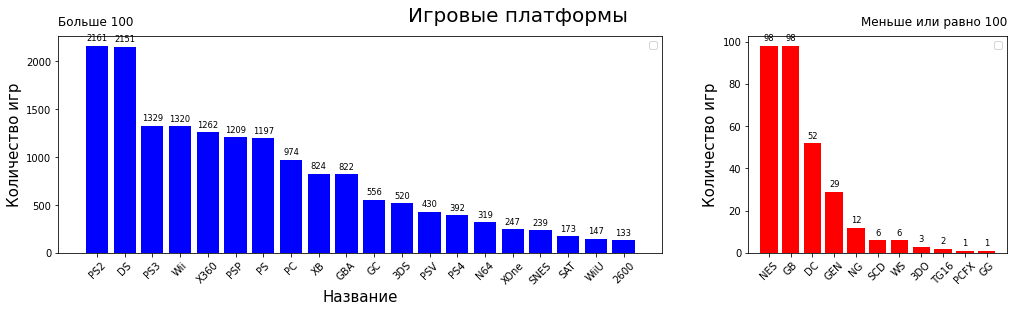

In [19]:
def draw_chart_div_by_lim(data,column,title='',unit='',limit=100, color='blue',legend='',y_label='Количество игр', ax='', figHight=4
                          , returnBigger=False, Return_div=False, SortIndex=False, pltShow=True, return_ax=False):
    
    '''
    Функция для вывода графиков и фильтрации по лимиту записей
    Возвращает список значений больше или меньше лимита 
    в зависимости от переменной returnBigger
    '''
    #UPD
    def autolabel(bars,ax):
        
        """
        Добавляет значение высоты столбца над каждым столбцом
        """
        for bar in bars:
            height = bar.get_height()
            ax.annotate('{}'.format(height),
                #annotation_clip=False,
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords='offset points',
                ha='center', va='bottom'
                       , size = 'small')
    #UPD-end    
    bars = ''
    chart = pd.DataFrame(data[column].value_counts())    
    chart_2 = chart.query(column + ' <= @limit').copy()
    chart_1 = chart.query(column + ' > @limit').copy()
    
    if SortIndex:
        chart_2.sort_index(ascending=True, inplace=True)        
        chart_1.sort_index(ascending=True, inplace=True)        
        
    #формирование сетки для вывода графиков

    if ax == '': #Если система координат не передана, то фигура и координаты создаются заново
        if len(chart_2) > 0: #Если выборка меньше лимита не пуста
                             #Создаём фигуру на два графика   
            fig, ax = plt.subplots(1,2,figsize=(17, figHight), gridspec_kw={'width_ratios': [7, 3]})                      
        else:            
                             #Иначе на один графика   
            fig, ax = plt.subplots(figsize=(17, figHight)) 
        fig.suptitle(title, fontsize=20)
    else:
        plt.title(title, fontsize=20)

    if type(ax) == np.ndarray:
        ax2 = ax[1]
        ax = ax[0]

    if len(chart_1) > 0:
#             bars = chart_1.plot.bar(ax=ax, color=color)
        bars = ax.bar(chart_1.index.astype('str'),chart_1[column], color=color) #UPD
        autolabel(bars,ax)                                        #UPD 
        ax.legend(legend)
        ax.set_ylabel(y_label, fontsize=15, color='black')
        ax.set_xlabel(unit, fontsize=15, color='black')   
        ax.tick_params(axis='x', labelrotation=45)
            
    if len(chart_2) > 0:    
        ax.set_title(f'Больше {limit}',loc = 'left',pad = 10) 
#         chart_2.plot.bar(ax=ax2, color='red') 
        bars = ax2.bar(chart_2.index.astype('str'),chart_2[column], color='red') #UPD
        autolabel(bars,ax2)                                        #UPD 
            
        ax2.set_ylabel(y_label, fontsize=15, color='black') 
        ax2.set_title(f'Меньше или равно {limit}',loc = 'right',pad = 10)  
        ax2.legend('')
        ax2.tick_params(axis='x', labelrotation=45)
    
    if pltShow: plt.show()             

    if Return_div:
        if returnBigger:
            return chart_1
        else:
            return chart_2
    if return_ax: return ax
        
platfor_other = draw_chart_div_by_lim(games_history,'platform','Игровые платформы','Название', Return_div=True)


In [20]:
try:
    #Добавление новой категории в категориальную переменную
    games_history['platform'] = games_history['platform'].astype('category').cat.add_categories(['OTHER'])      
except: None    
games_history['platform'] = games_history['platform'].where(~games_history['platform'].isin(platfor_other.index),'OTHER')
try:
    #Удаление категорий из категориальной переменной
    games_history['platform'] = games_history['platform'].astype('category').cat.remove_categories(platfor_other.index)
except: None        

Одинаковых категорий игровых платформ не обнаружено. Платформы с количеством игор меньше 100, объединим в общую категорию <b>OTHER</b> - другие

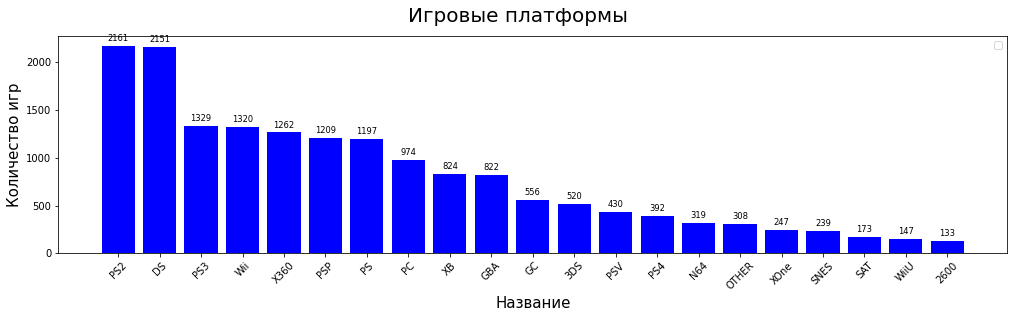

In [21]:
draw_chart_div_by_lim(games_history,'platform','Игровые платформы','Название')

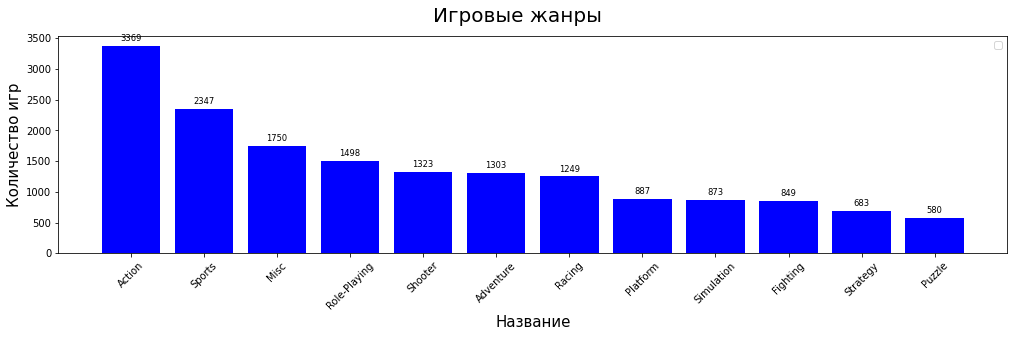

In [22]:
draw_chart_div_by_lim(games_history,'genre','Игровые жанры','Название')

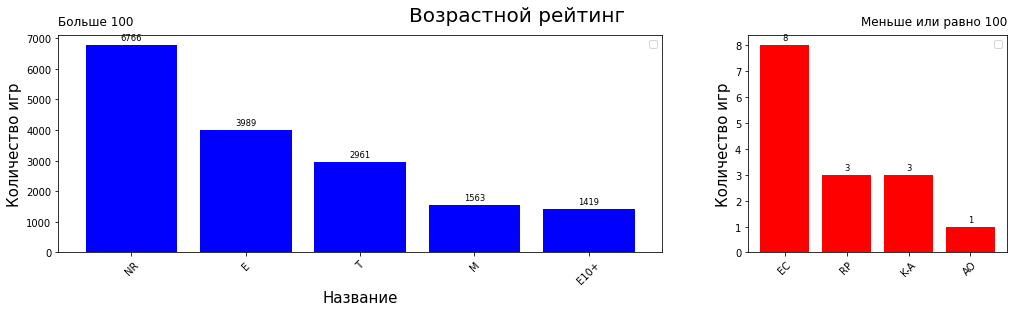

In [23]:
draw_chart_div_by_lim(games_history,'rating','Возрастной рейтинг','Название')

Одинаковых категорий игровых жанров не обнаружено.

### Подсчёт суммарных продаж во всех регионах для каждой игры

In [24]:
#Создадим столбец суммарных продаж во всех регионах для каждой игры
games_history['all_sales'] = ( games_history['na_sales'] + games_history['eu_sales'] 
                            + games_history['jp_sales'] + games_history['other_sales']
                             )
info_print(games_history, 'Проверим отсутствие пропусков, типы данных и суммарные продажи',prntGraph=False)


 Проверим отсутствие пропусков, типы данных и суммарные продажи 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16713 entries, 0 to 16714
Data columns (total 12 columns):
name            16713 non-null object
platform        16713 non-null category
year            16713 non-null int32
genre           16711 non-null object
na_sales        16713 non-null float64
eu_sales        16713 non-null float64
jp_sales        16713 non-null float64
other_sales     16713 non-null float64
critic_score    16713 non-null int32
user_score      16713 non-null float64
rating          16713 non-null object
all_sales       16713 non-null float64
dtypes: category(1), float64(6), int32(2), object(3)
memory usage: 2.0+ MB
Количество дубликатов: 0
Пример первых 5 записей:


,name,platform,year,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,all_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76,8.0,E,82.54
1,Super Mario Bros.,OTHER,1985,Platform,29.08,3.58,6.81,0.77,0,0.0,NR,40.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82,8.3,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80,8.0,E,32.77
4,Pokemon Red/Pokemon Blue,OTHER,1996,Role-Playing,11.27,8.89,10.22,1.00,0,0.0,NR,31.38


# Часть 2. Исследовательский анализ данных

## Поиск интервала исследования. Анализ количества игр по годам и платформам

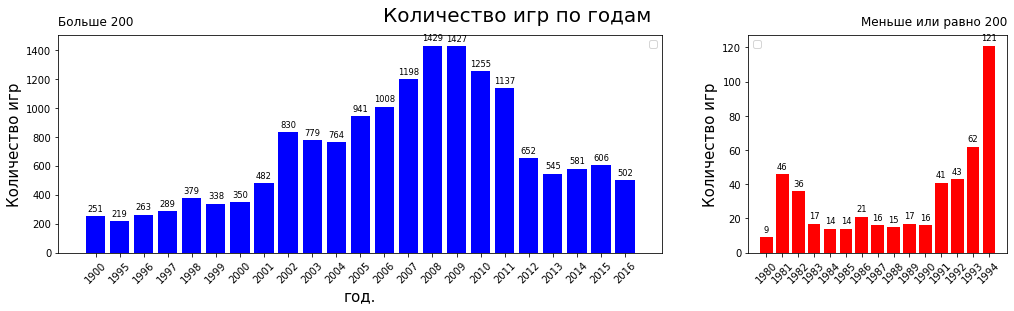

In [25]:
draw_chart_div_by_lim(games_history,'year','Количество игр по годам','год.',limit=200,SortIndex=True)              

Нам интересны современные тенденции в играх. Данные годов когда выходило меньше 100 игр нам совсем неинтересны.
А вот из более мене последнего, в графике с 2008 г. прослеживается резкое падение количества игр вышедших за год
с 2012 нисходящий тренд выравнивается, и именно этот промежуток будет целесообразнее взять для анализа.

In [26]:
def create_curv_dic(data,column):
    '''
    Функция для создания словаря
    Хранящего список типов линий и их цветов
    для соответствующих названий для одинакового отображения 
    линий на графиках
    '''
    curv_dic = pd.DataFrame(columns=['curv_type', 'curv_color'])
    curv_name = data[column].unique()
    #Список стилей для линий
    line_stel_list = ['--', '-.', '-', ':'] 
    #массив цветов линий    
    colors = [plt.cm.tab10(c/float(len(curv_name)-1)) for c in range(len(curv_name))]
    clo_of_line = 0 #селектор цвета
    stl_of_line = 0 #селектор типа линии    
    
    for val in curv_name:                
        if stl_of_line >= len(line_stel_list): stl_of_line=0                          
        curv_dic.loc[val,'curv_type'] = line_stel_list[stl_of_line]
        curv_dic.loc[val,'curv_color'] =  colors[clo_of_line]             
        stl_of_line += 1
        clo_of_line += 1 
    return curv_dic

In [27]:
#draw_chart_div_by_lim(games_history,'platform','Количество игр по годам','год.',limit=200,SortIndex=True)       

def draw_chart_by_year(data, index ,columns ,values, aggfunc, title, unit,  y_unit
                       , ncol=2, figHight=7, rng=[], rng_title=[], top=0
                       , curv_dic='', drawNotAlive=True, whatReturn=''):
    #Сводная таблица по годам и платформам
    
    
    def top_n(data, top_n):
        '''
        Функция для расчёта рейтинга n
        all_yr средние продажи за весь выбранный период
        rt_3 рейтинг за последние 3 года. Средние продажи за последние 3 года 
        с в влиянием на среднее last - 2 * 1, last - 1 * 2, last * 3
        last - продажи за последний год
        
        '''
        top = pd.DataFrame()
        pref = re.search(r'.*_', values)[0]        
        
        
        top[pref+'rt_3'] = round((
                                data.iloc[:,-3].fillna(0)
                               + data.iloc[:,-2].fillna(0)*2
                                + data.iloc[:,-1].fillna(0)*3
                                ) / 6 ,2).fillna(0) 
        top[pref+'last'] = data.iloc[:,-1].fillna(0)
        top[pref+'all_yr'] = round(data.mean(axis=1),1).fillna(0)
        
        top.index.names = [pref+re.search(r'.{4}', index)[0]]        
        return top.sort_values(by=pref+'rt_3', ascending=False).head(top_n)

    def count_platfor_life(row):
        '''
        Функция возвращает первый и последний год жизни платформы
        А так-же количество лет в которые на ней выходили игры
        '''
        y_life, last_y, first_y, alive = 0, 0, 0, False
        StarBit = True
        for i, v in row.items():                                                          
            if v > 0: 
                y_life += 1
                last_y = i   
                if StarBit:
                    StarBit = False
                    first_y = i                                
        
        if i == last_y: alive = True
        return [first_y, last_y, y_life, alive]
    #Создаём сводную таблицу
    pivot_data = data.pivot_table(index=index, columns=columns, values=values, aggfunc=aggfunc)
                         
    if top>0: 
        top_n_table = top_n(pivot_data, top)
        pivot_data = pivot_data.query(f'{index} in @top_n_table.index').fillna(0).copy()
      
    pivot_data.sort_values(by=pivot_data.columns[-1], ascending=False, inplace=True)    

    
         
    fig = plt.figure(figsize=(20, figHight)) #создание фигуры для рисования графиков 
    ax = fig.add_subplot(111) #создание осей координат для рисования графиков    
    #Создание перечня значений для шалы Х
    rng = range(pivot_data.columns.min(),pivot_data.columns.max()+1,1) 
    #Список стилей для линий
    line_stel_list = ['--', '-.', '-', ':'] 
    #массив цветов линий
    colors = [plt.cm.tab10(c/float(len(pivot_data)-1)) for c in range(len(pivot_data))]
    clo_of_line = 0 #селектор цвета
    stl_of_line = 0 #селектор типа линии
    color_v, line_v = '',''
    platform_life = pd.DataFrame(columns=['platform', 'first_year', 'last_year', 'life','alive'])
    
    for i, row in pivot_data.iterrows():
        #Заполнение таблицы м годами жизни платформ
        first_y, last_y, y_life, alive = count_platfor_life(row)
        if alive or drawNotAlive:
            platform_life = platform_life.append({'index_plat': i,'platform': i,'first_year':first_y,'last_year':last_y
                                                  ,'life': y_life, 'alive':alive},ignore_index=True)
            # Вывод графиков НАЧАЛО
            if stl_of_line >= len(line_stel_list): stl_of_line=0  
            label = f'{i}' 
            if alive: label += ' ✔'
            if type(curv_dic) == pd.core.frame.DataFrame:
                
                color_v = curv_dic.loc[i,'curv_color']
                line_v = curv_dic.loc[i,'curv_type']
            else:
                color_v = colors[clo_of_line]
                line_v = line_stel_list[stl_of_line]
                
            row.plot(linestyle=line_v, color=color_v 
                     ,ax=ax, grid=True, rot=45, alpha=0.7, label=label)         
            stl_of_line += 1
            clo_of_line += 1
            # Вывод графиков КОНЕЦ
    #Подготовка результирующей таблицы
    platform_life = platform_life.set_index('index_plat')
    platform_life['life'] = platform_life['life'].astype('int')
    platform_life['first_year'] = platform_life['first_year'].astype('int')
    platform_life['last_year'] = platform_life['last_year'].astype('int')
    platform_life['alive'] = platform_life['alive'].astype('bool')    
    #отрисовка графиков НАЧАЛО
    med_plat_life = platform_life["life"].median()    
    plt.title(f'{title}', fontsize=25)
    plt.legend(ncol=ncol, fontsize='x-large', loc='upper left')  
    plt.ylabel(y_unit, fontsize=15, color='black')
    plt.xlabel(unit, fontsize=15, color='black')
    plt.ylim(0.01)
    if rng_title == []:
        rng_title = rng
    if rng != []:
        plt.xticks(rng,rng_title) 
    plt.show()         
    #отрисовка графиков КОНЕЦ
    if whatReturn == 'lifePlatform': return platform_life
    if whatReturn == 'pivotTable' : 
        return pivot_data.query(f'{index} in @platform_life.index')
    if top>0: return top_n_table

In [28]:
#создание словаря линий для platform
platform_curv_dic = create_curv_dic(games_history,'platform')

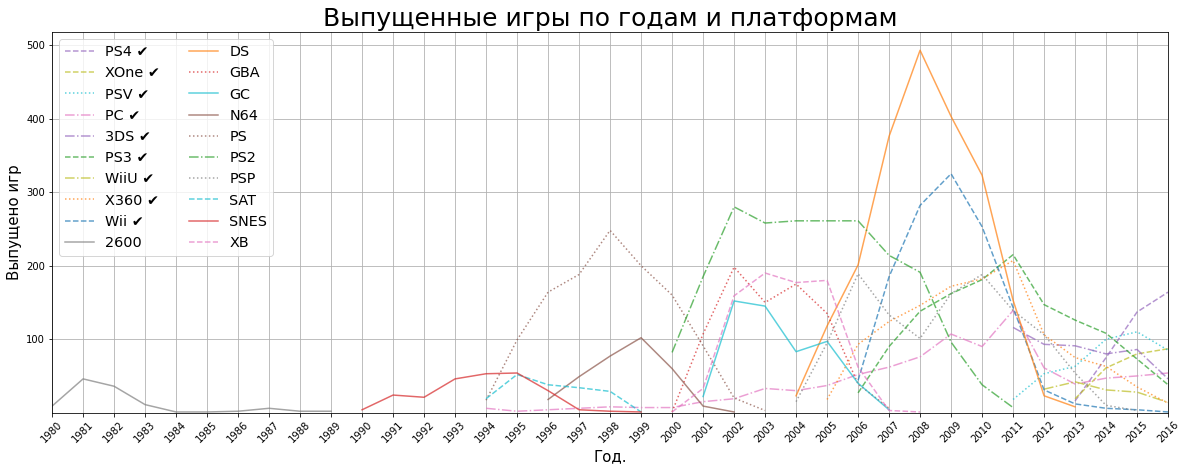

In [29]:
draw_chart_by_year(games_history.query('year > 1900 and platform != "OTHER"'),'platform','year','all_sales'
                                   ,'count','Выпущенные игры по годам и платформам','Год.','Выпущено игр'
                   ,curv_dic=platform_curv_dic)

После анализа общего количества игр вышедших по годам мы пришли к мнению, что интерес представляет тренд среднего падения рынка начиная с 2012 г.

Но при анализе графиков по платформам выяснилось, что в резком падении рынка игр с 2008 г. виноваты две конкретные платформа DS - Nintendo DS Портативная игровая система и Wii - Nintendo Wii. Так как это довольно разные платформы, но принадлежащие одному производителю, то будем считать, что их влияние на график больше зависели от политики компании, чем от каких бы то ни было тенденций на игровом рынке. Исключая эти два графика, можно проследить примерную тенденцию с 2002 года.

Появления новых платформ существующих по сей день и тенденция на снижение платформ существующих ранее приходится примерно на 2008 - 2010 годы. В среднем 2009.

Не смотря на то, что с того момента некоторые платформы потеряли актуальность, мы всё равно возьмём это промежуток, т.к. какие-то платформы могут менять друг друга из-за технического развития, тенденции в самих играх могут сохранятся.

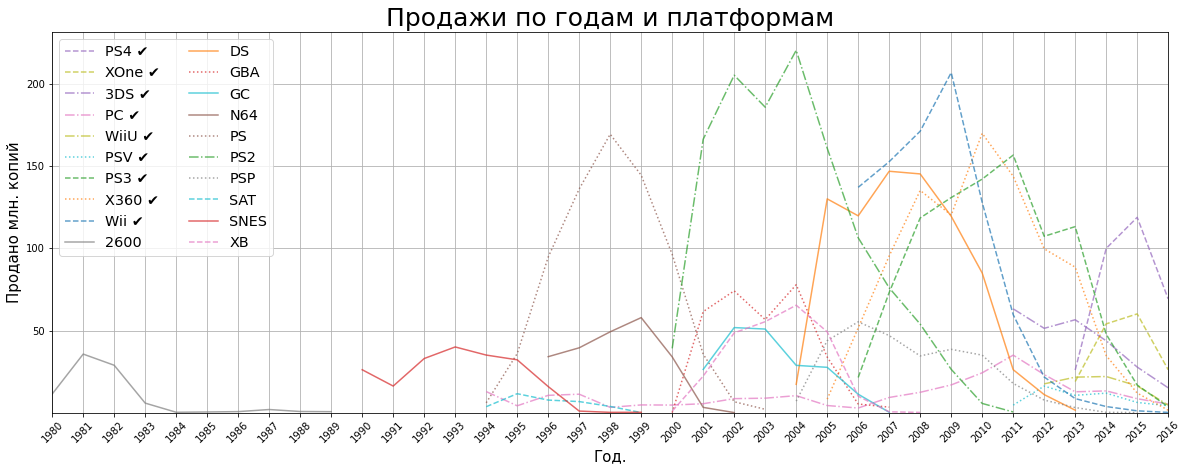

In [30]:
platform_life = draw_chart_by_year(games_history.query('year > 1900 and platform != "OTHER"'),'platform','year','all_sales'
                                   ,'sum','Продажи по годам и платформам','Год.', 'Продано млн. копий'
                                   , curv_dic=platform_curv_dic ,whatReturn='lifePlatform')

Анализируя продажи, мы видим что спрос на игры для определенных платформ меняется периодически, начиная расти на старте и после определённого пика в середине карьеры падает вплоть до ноля.

Не во всех случаях популярность платформы у производителей (выпуск игр.) и популярность платформы у покупателей ровны. Нам как продавцу более интересна популярность платформы у пользователей и как эта популярность изменится в будущем.

Хоть нам и интересы тенденции в играх в период с 2009 года, платформы же нам интересны только те, которые до сих пор существуют и те, которые не находятся на закате своей популярности.

## Средняя продолжительность жизни игровых платформ

Среднее: 9.35 

Стандартное отклонение: 4.64 

Доверительный интервал: от -4.57 до 23.27 



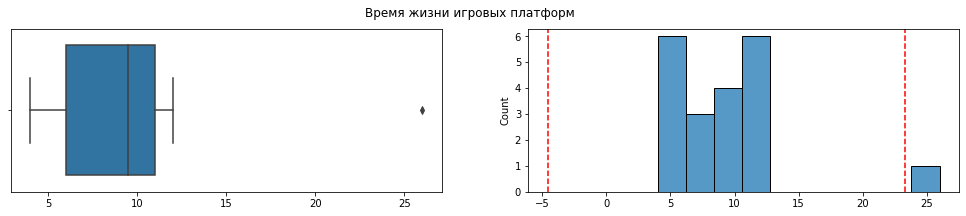

Среднее: 9.27 

Стандартное отклонение: 1.96 

Доверительный интервал: от 3.4 до 15.15 



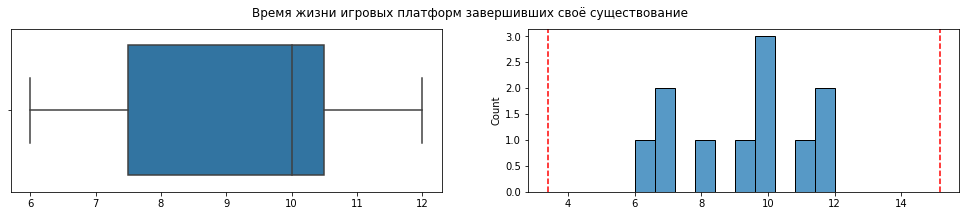

In [31]:
#Формируем таблицу с актуальными данными
actual_games_history = games_history.query('year > 2008')
info_print (platform_life,'Время жизни игровых платформ', column='life',bins=10, prntInfo=False, prntGraph=True)

#получаем среднее время жизни платформы и Стандартное распределение
plat_live_mu, plat_live_sigma = info_print (platform_life.query('not alive')
            ,'Время жизни игровых платформ завершивших своё существование'
            , column='life', bins=10, prntInfo=False, prntGraph=True, returnMetric=True)
plat_live_mu = round(plat_live_mu)

Среднее время жизни платформы если её округлить 9 лет, это время за которое меняется игровая эпоха. 

С учётом этого логично выбрать промежуток от 2007 г. С учётом исследования предыдущего графика возьмём среднее между 2007 и 2009 г. 2008 г.

Т.е. актуальный промежуток для нашего последующего исследования будет 2008-2016 г.г. выхода игр.
И конечно же учтём среднее время жизни при выборе платформы.

## Актуальные платформы

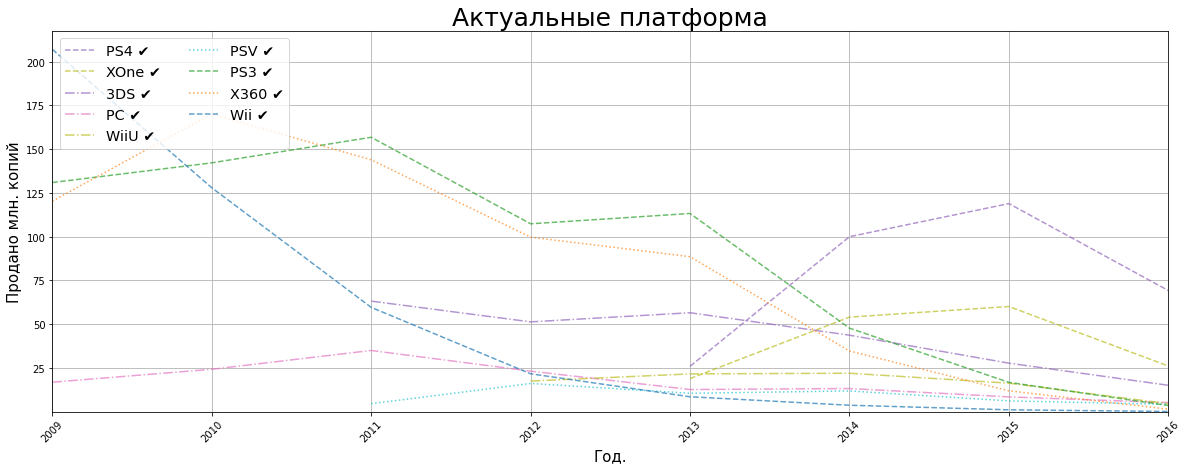

,platform,life,2015,2016,coeff,2017
0,PS4,4,118.90,69.25,0.78,54.02
1,XOne,4,60.14,26.15,0.66,17.26
2,3DS,6,27.78,15.14,0.57,8.63
3,PC,26,8.52,5.25,0.62,3.25
5,PSV,6,6.25,4.25,0.63,2.68
4,WiiU,5,16.35,4.60,0.43,1.98
6,PS3,11,16.82,3.60,0.26,0.94
7,X360,12,11.96,1.52,0.20,0.30
8,Wii,11,1.14,0.18,0.21,0.04


In [32]:
actual_platform_sales = draw_chart_by_year(actual_games_history
                                          ,'platform','year','all_sales'
                                           ,'sum','Актуальные платформа','Год.','Продано млн. копий'
                                          ,curv_dic=platform_curv_dic ,drawNotAlive=False,whatReturn='pivotTable').reset_index()

def mean_coeff(row):
    '''
    Функция подсчёта  
    коэффициента изменения продаж за последние 3 месяца
    На коэффициент влияет в большой степени изменение за последний год
    И в 2 раза меньше изменения за предыдущий
    ''' 
    last_ind = len(row)-1
    return  round(
                    (2*row.iloc[last_ind]/row.iloc[last_ind-1] 
                     + row.iloc[last_ind-1]/row.iloc[last_ind-2]) /3
                ,2)

actual_platform_sales['coeff'] = actual_platform_sales.apply(mean_coeff, axis=1) 
actual_platform_sales[2017] = round(actual_platform_sales[2016] * actual_platform_sales['coeff'],2)
display(platform_life.merge(actual_platform_sales, on='platform', how='right')
         [['platform','life',2015,2016,'coeff',2017]].sort_values(by=2017, ascending=False))

Из данного графика и таблицы мы видим, что 3 из перечисленных платформы **PS3, X360, Wii** уже превысили среднюю продолжительность жизни и близки к завершению своего существования. Что подтверждает наименьшие продажи из нашего рейтинга. У всех, кроме **PC** - Персональный компьютер это долгожитель в мире игровых платформ, он пока не собирается покидать рыбном, это особенность платформы обоснованная заменой аппаратного обеспечения при сохранении самой платформы. 

Таблица отсортирована по прогнозируемым в 2017 году продажам основанным на отношении продаж за два последних года.

К сожалению, у нас нет платформ продажи которых бы росли, т.к. в принципи наблюдается снижения продаж на данном рынке.

Но вот платформа **WiiU** которая ещё не добралась до среднего времени выбывания, упала по сравнению с предыдущим годом больше чем в 3,5 она и так имела почти самые минимальные продажи а с такими темпами в следующей году её в предсказанные продажи в два раза меньше, чем у следующей за ней платформой.Очень резкий спад продаж **PS3** обусловлено тем, что на её смену пришла **PS4**, благодаря чему её продажи будут стремиться к 0.

Выгодные и перспективные платформ это:
**PS4** - Абсолютный лидер продаж и **XOne,3DS** c почти 4-x кратным отставанием от PS4 но не значительной разницей между собой. И конечно же PC он хоть и не показывает огромных результатов, но зато имеет максимально стабильный график продаж по сравни. с конкурентами, что обусловлено его особенностями. Но это не говорит, что нужно совсем отказываться от **PSV и WiiU** к ним нужно отнестись повнимательнее.
    А вот к **PS3, X360, Wii** требуют максимальной осторожности. Их лучше избегать.

## Глобальные продажи игр по платформам

Среднее: 267.02 

Стандартное отклонение: 220.98 

Доверительный интервал: от -395.91 до 929.96 



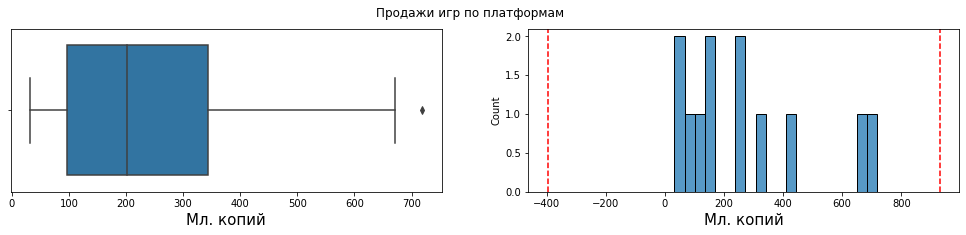

In [33]:
info_print(actual_games_history
           .groupby(by='platform').sum()
           .query('all_sales > 0')
            ,'Продажи игр по платформам'
            , column='all_sales',unit='Мл. копий', bins=20, prntInfo=False, prntGraph=True)            

Единичные платформы на рынке, их меньше 10%, имеют продажи превышающий в 3,5 раза продажи средней платформы.

На одну проданную игру средней платформы приходится 2,5-3,5 игры топовой. Но таких платформ в 2 раза больше. 
Т.е. Средняя платформа может принести в 3 раза меньше меньше, чем лидеры рынка, но лидеров ни так много.

Всё это говорит о том, что выбор платформы очень важен, то под какую платформу выпущена игра будет влиять на её продажи.

## Влияние отзывов на продажи игр.

In [34]:
def draw_scatter(data, x=['critic_score','user_score'], y='all_sales', title='Объёмы продаж'
                 , x_unit=['Оценки критиков', 'Оценки пользователей'],  y_unit='Продажи млн. копий'
                 ,figHight=4):
    '''
    Функция для вывода постройки диаграммы рассеяния 
    и подсчёта корреляции оценками и продажами
    '''
    
    fig, ax = plt.subplots(1,2,figsize=(17, figHight),sharey=True,gridspec_kw={'width_ratios': [1, 1]})
    fig.suptitle(f'Объёмы продаж '+title, fontsize=20)  
    min_sales = data[y].min()*100
    max_sales = data[y].max()*100
    
    def draw_scatter(x, x_unit, ax, sub_title_align):
    
        # Вывод графиков НАЧАЛО
        min_score = data[x].min()
        max_score = data[x].max()

        # Вывод графиков КОНЕЦ
        sns.scatterplot(data=data, x=x, y=y, ax=ax, legend=False
                        , hue=x, hue_norm=(min_score, max_score)
                        , size=y, sizes=(min_sales, max_sales))                      
        ax.set_ylabel(y_unit, fontsize=15, color='black') 
        ax.set_xlabel(x_unit, fontsize=15, color='black') 
        ax.set_title(
            f'Коэффициент корреляции Пирсона: '+
            f'{round(data[x].corr(data[y]),2)}',
            loc = sub_title_align , fontsize=15)  
        ax.legend('')                                                   
        #отрисовка графиков НАЧАЛО 
                   
    draw_scatter(x[0], x_unit[0], ax[0],'left')        
    draw_scatter(x[1], x_unit[1], ax[1],'right')        
    plt.show()    
    
#Создание среза PS4    
feed_back = (
                    actual_games_history
                    .query('critic_score > 0')
                    [['name','platform','year','genre','critic_score','user_score','all_sales']]
                )  

### Влияние отзывов на продажи игр на примере топовой платформы PS4

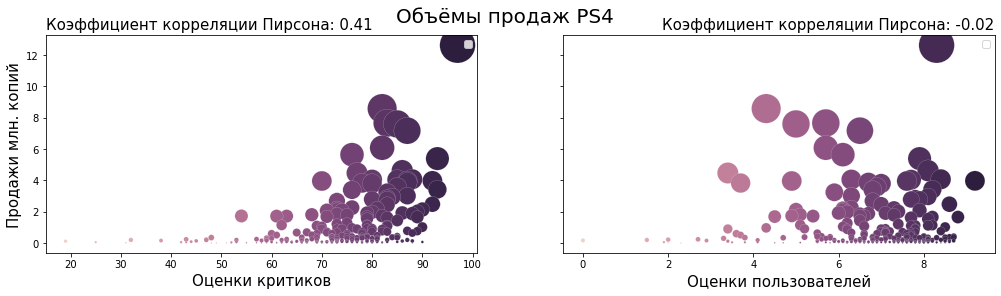

In [35]:
draw_scatter(feed_back.query('platform == "PS4"'), title='PS4')

Как видно из графиков и коэффициента корреляции, между оценками критиков и объёмами продаж на платформе PS4 есть средняя прямая связь. А вот между оценками оценками пользователей и продажами прямо связи нет. Т.е. при покупке пользователи обращают внимание на оценки критиков, а вот мнение других пользователей практически не учитывают. 

Ставят ли критики высокие оценки тем же играм, за которые пользователи голосуют рублём.Или пользователи голосуют рублем за те игры которым ставят высокие оценки критики. Вопрос остаётся открытым, особенно при учёте отсутствия корреляции оценок пользователей с объёмами продаж.

В любом случаи какая-то связь между оценками критиков и продажами есть, стоит обращать на них внимание.
Что покажут другие платформы.

### Влияние отзывов на продажи игр на других платформах

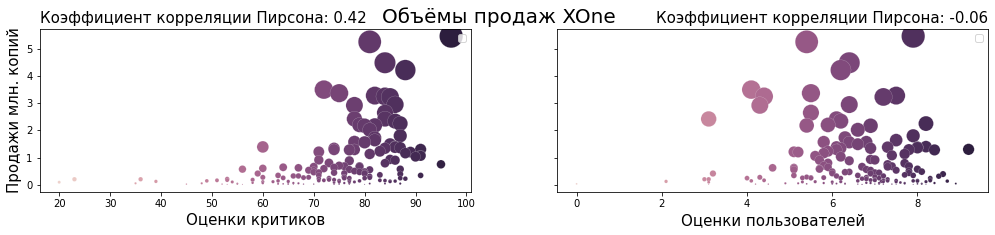

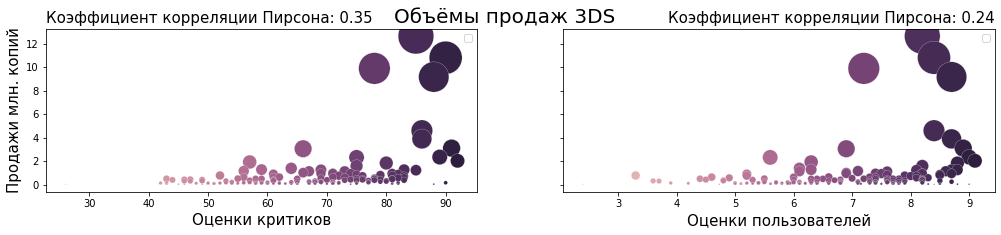

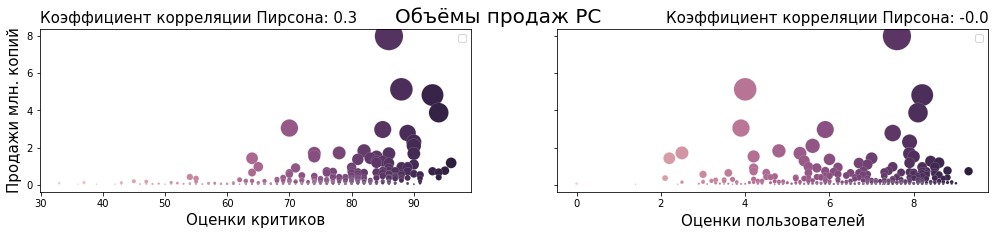

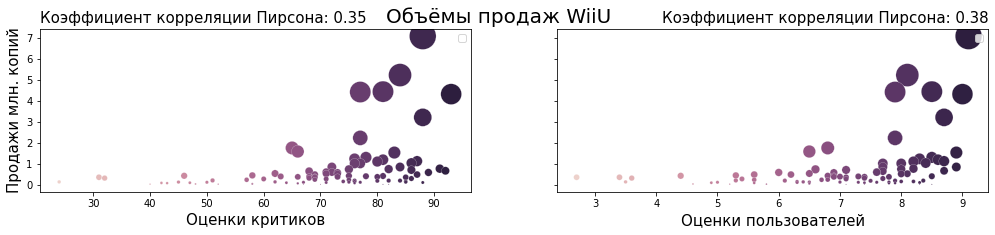

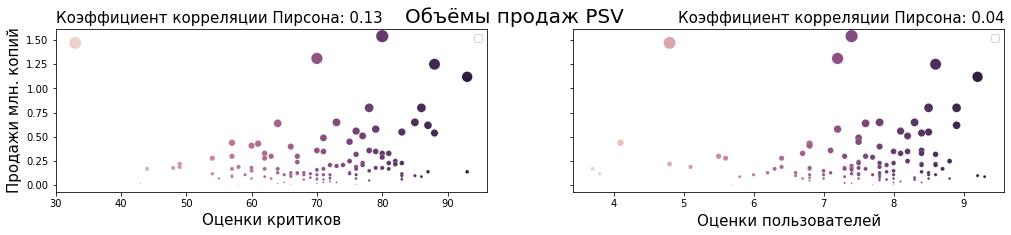

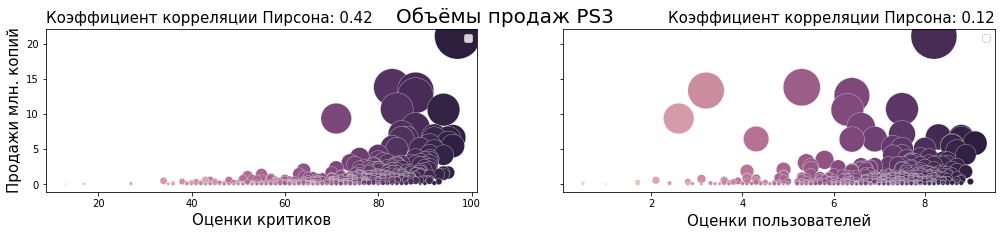

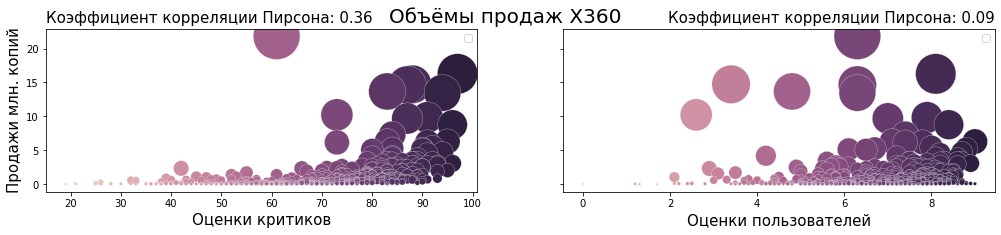

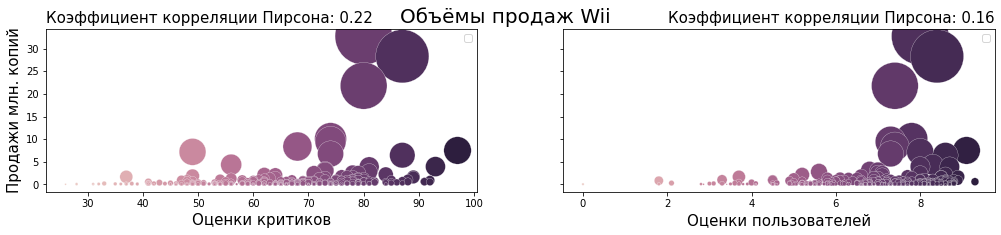

In [36]:
for ind, val in actual_platform_sales['platform'].items():
    if val != 'PS4':
        draw_scatter(feed_back.query('platform == @val'), title=val,figHight=3)

На многих платформах с оценками близка к PS4. Наблюдается прямая связь продаж с оценками критиков от средней до слабой.
И связь продаж с отзывами пользователей от слабой до никакой.

Но есть и исключения на: PC корреляции нет ни с оценками пользователей, ни с оценками критиков. Видимо пользователи PC более независими. Но это платформа во всём особенная, так что это не удивительно.

А вот на платформе WiiU обе корреляции хоть и незначительны но равны между собой.

В итоге за редкими исключениями можно заключить, что оценки критиков имеют влияние на объёмы продаж почти на всех платформах, а вот на отзывы пользователей пользователи не смотрят при покупке.

## Распределение игр по жанрам

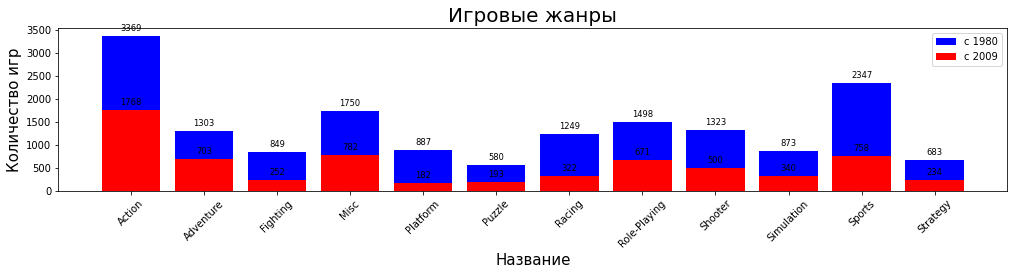

In [37]:
ax = draw_chart_div_by_lim(games_history,'genre', SortIndex=True, pltShow=False, return_ax=True, figHight=3)
draw_chart_div_by_lim(actual_games_history,'genre','Игровые жанры','Название' 
                      , legend=['c 1980','c 2009']
                      , SortIndex=True, ax=ax, color='red')

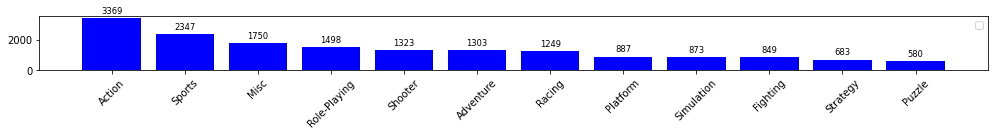

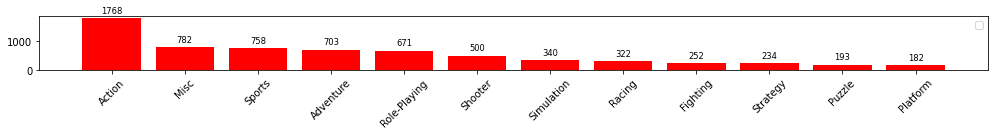

In [38]:
draw_chart_div_by_lim(games_history,'genre',y_label='',figHight=1)
draw_chart_div_by_lim(actual_games_history,'genre',y_label='', color='red',figHight=1)

Жанр **Action** лидер по количеству выпущенных игр как за всё время так и за последние годы.
На данный момент своего ближайшего конкурента он обгоняет больше чем в два раза. За последние годы темпы выпуска игр жанра Action увеличились. Явными аутсайдерами являются **Fighting, Strategy, Puzzle и Platform**

In [39]:
#создание словаря линий для genre
genre_curv_dic = create_curv_dic(games_history,'genre')

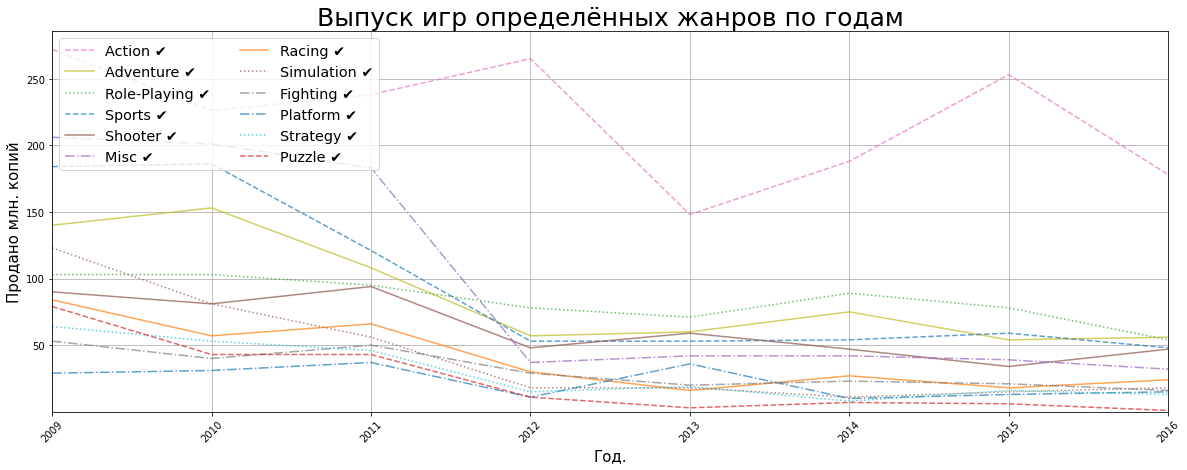

year,genre,2009,2010,2011,2012,2013,2014,2015,2016
0,Action,272,226,238,265,148,188,253,178
1,Adventure,140,153,108,57,60,75,54,56
2,Role-Playing,103,103,95,78,71,89,78,54
3,Sports,184,186,121,53,53,54,59,48
4,Shooter,90,81,94,48,59,47,34,47
5,Misc,206,201,183,37,42,42,39,32
6,Racing,84,57,66,30,16,27,18,24
7,Simulation,123,81,56,18,18,11,15,18
8,Fighting,53,40,50,29,20,23,21,16
9,Platform,29,31,37,11,36,10,13,15


In [40]:
actual_genre = draw_chart_by_year(actual_games_history,'genre','year','all_sales'
                                   ,'count','Выпуск игр определённых жанров по годам','Год.','Продано млн. копий'
                                  ,curv_dic=genre_curv_dic,whatReturn='pivotTable').reset_index()
display(actual_genre.sort_values(by=2016, ascending=False))

Если посмотреть в перспективу, то видно, что по количеству выпуска игр, жанр **Action** остаётся примерно на том же уровне.

А вот все остальные жанры снижают количество выпусков и перестраивают рейтинг.
Жанр **Misc** со второго места упал куда-то на середину рейтинга снизив количество выпускаемых игр больше чем в 4 раза.

Почти то-же случилось с жанром **Sport и Adventure**
А как дело обстоит с продажами, так же хорошо покупают игры жанра **Action** как выпускают?

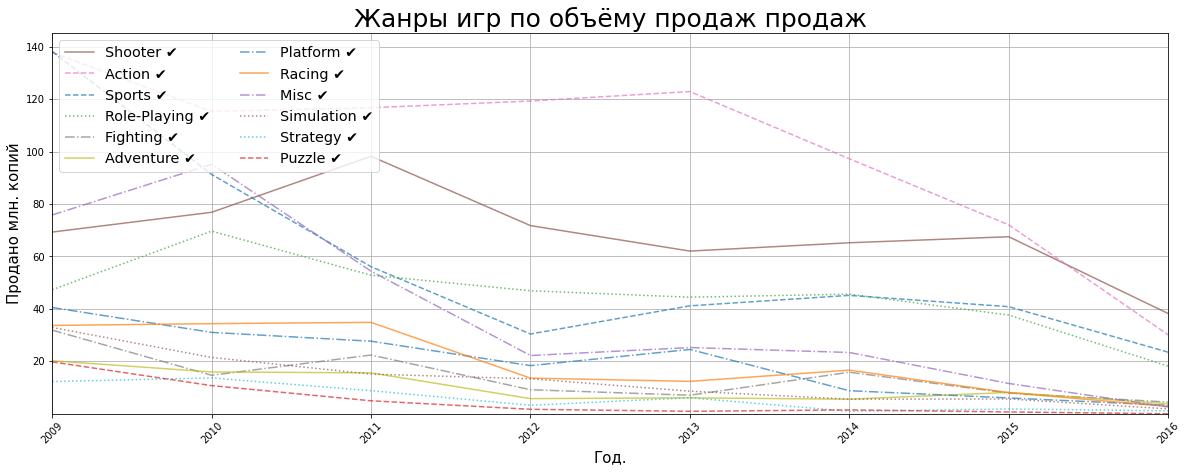

year,genre,2009,2010,2011,2012,2013,2014,2015,2016
0,Shooter,69.29,76.83,98.18,71.75,62.04,65.21,67.51,38.22
1,Action,137.69,115.29,116.68,119.25,122.86,97.23,72.02,30.11
2,Sports,138.17,91.24,56.08,30.42,41.17,45.15,40.84,23.49
3,Role-Playing,47.31,69.65,52.83,46.91,44.45,45.62,37.64,18.18
4,Fighting,31.90,14.69,22.41,9.18,7.09,15.85,7.90,4.47
5,Adventure,20.23,15.96,15.61,5.79,6.09,5.57,8.16,3.82
6,Platform,40.53,31.04,27.68,18.37,24.54,8.81,6.05,3.23
7,Racing,33.69,34.37,34.86,13.61,12.37,16.66,8.07,2.79
8,Misc,75.81,95.14,54.38,22.22,25.27,23.38,11.57,2.60
9,Simulation,32.92,21.49,15.14,13.36,8.63,5.58,5.66,1.89


In [41]:
actual_genre_sales=draw_chart_by_year(actual_games_history,'genre','year','all_sales'
                                   ,'sum','Жанры игр по объёму продаж продаж','Год.','Продано млн. копий'
                                ,curv_dic=genre_curv_dic,whatReturn='pivotTable').reset_index()
display(actual_genre_sales.sort_values(by=2016, ascending=False))

Игр жанра "Shooter" в 2016 году было выпущено в 3 раза меньше, чем игр жанра "Action" но при этом жанр "Shooter" вышел в лидирующие позиции по продажам. Получается, что игры некоторых жанров настолько популярны, что их покупают даже больше количество новинок в жанрах конкурентах. 

Жанр "Action" ранее занимал лидирующую позицию, ни только по количеству новых игр, но и по продажам, но по какой-то причини продажи именно этого жанра упали в последнем году.
Есть 4 основных жанра выделяющихся на фоне остальных. 

**Shooter, Action, Sports, Role-Playing** последний их которых в 4 раза превышает по продажам следующего за ним в рейтинге конкурента. Жанр **Puzzle** практически вообще не продаётся. Жанры **Strategy и Simulation** Имеют самые низкие продажи.


# Вывод
По итогам данной части можно сделать вывод, что при выборе удачной игры в большой степени нужно обращать внимание на платформу и жанр и в меньшей степени на отзывы пользователей. Спрос на определённые платформы и жанры очень сильно меняется.

На данный момент самые выгодные платформы:
**PS4	XOne 3DS PC**
А самые популярные жанры
**Shooter, Action, Sports, Role-Playing**

# Часть 3. Портрет пользователя отдельного региона

In [42]:
sales_name = ['na_sales', 'eu_sales', 'jp_sales']
sales_titles = pd.Series({'na_sales': 'в Северной Америке'
                              , 'eu_sales': 'в Европе'
                              , 'jp_sales': 'в Японии'
                             })
        #,index=sales_name)
    
def draw_top_charts(data_table, index, title='', dispTable=False, top=5, **kwargs):
    '''
    Функция для вызова отрисовки топ рейтингов по асем странам
    При помощи функции draw_chart_by_year рисуем  графики
    И возвращает массив с рейтингами по каждой стране
    таблица рейтингов содержит 3 столбца 1: место в рейтинге 
    место назначается по максимальным продажам за последний год
    2: средние продажи за рассматриваемый период
    3: Продажи за последний год
    '''    
    top_n_arr = {}
    for val in sales_name:    
        top_n_arr[val] = draw_chart_by_year(data_table, index,'year',val,'sum'
                                                            ,f'{title} {sales_titles[val]}','Год.','Продано млн. копий'
                                                            ,ncol=1, top=top, figHight=3, **kwargs).reset_index()
        if dispTable: display(top_n_arr[val])   
 
    return top_n_arr

def draw_top_table(top_array='', title='---'):
    '''
    Функция отрисовки таблиц рейтинга в одну строку
    '''
    all_top = pd.DataFrame({'rate': [1, 2, 3, 4, 5]})
    for val in sales_name:        
        top_array[val]['rate'] = top_array[val].index.astype('int')+1
        all_top = all_top.merge(top_array[val], on='rate', how='right')        
    display(title)
    display(all_top.set_index('rate'))      

## Распределение продаж по платформам в разных странах

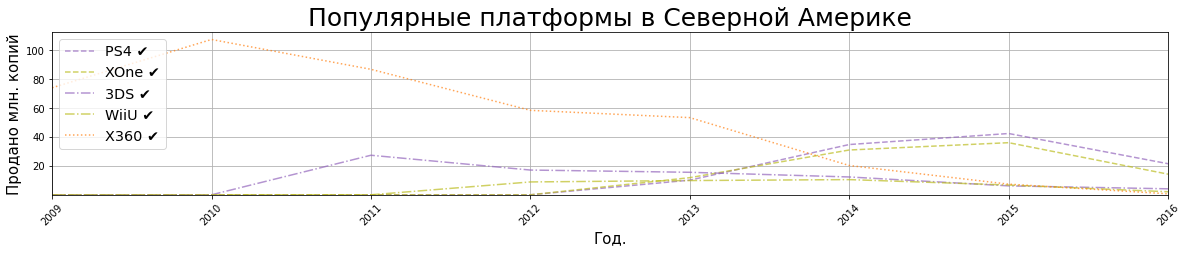

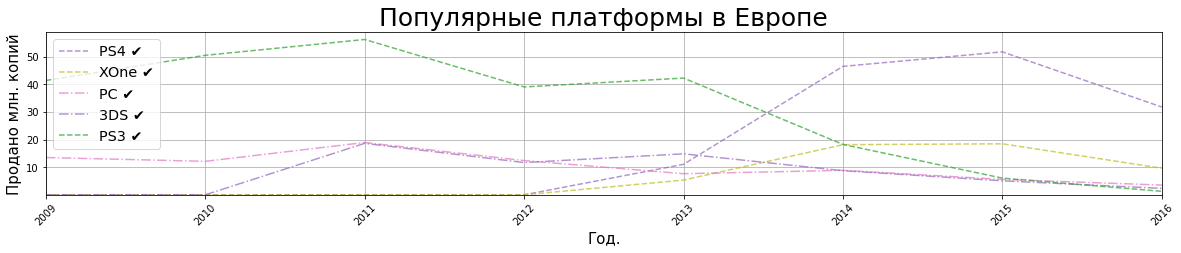

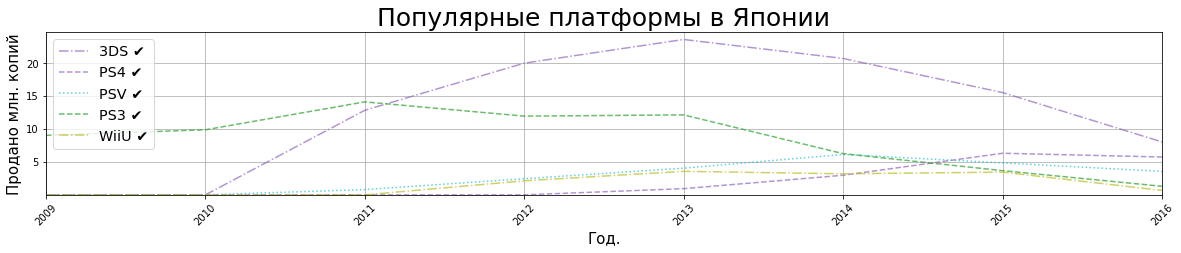

In [43]:
top_5_platform = draw_top_charts(actual_games_history, 'platform', title='Популярные платформы',curv_dic=platform_curv_dic)

In [44]:
draw_top_table(top_5_platform, title='Популярные платформы')

'Популярные платформы'

,na_plat,na_rt_3,na_last,na_all_yr,eu_plat,eu_rt_3,eu_last,eu_all_yr,jp_plat,jp_rt_3,jp_last,jp_all_yr
rate,,,,,,,,,,,,
1,PS4,30.66,21.49,27.2,PS4,40.89,31.78,35.3,3DS,12.64,8.03,16.8
2,XOne,24.31,14.27,23.3,XOne,14.00,9.63,12.9,PS4,5.47,5.74,4.0
3,3DS,6.18,4.14,13.8,PS3,5.68,1.26,31.9,PSV,4.42,3.56,3.6
4,X360,6.17,0.69,51.0,PC,5.10,3.53,10.3,PS3,2.91,1.30,8.5
5,WiiU,5.05,2.10,7.6,3DS,4.31,2.33,10.2,WiiU,2.02,0.67,2.6


Как видно рейтинг в разных странах разнится. Особенно отличается Япония, здесь на первом месте не **PS4**, а **3DS**

А **XOne** занимающая вторую строчку во всех других списках вообще не попала в пятёрку.
Рейтинг составлен на основании продаж за 3 последних года, продажи последнего года влияют на рейтинг в 3 раза больше чем продажи трёх летней давности. (формула Rate = (last_year * 3 + last_year-1 * 2 + last_year-2 * 1) /  6

Но всё равно, если рейтинг составлять только по последнему году, то позиции поменяются. 

В зависимости от времени в разных странах спрос на определенные платформы влияют по разному. Но всё таки топовые платформы имеют близкое соотношение продаж, за некоторым исключением. Статистика продаж по целевой стране даст более корректную картину для прогнозов.

<a id='18-bullet'></a>
## Распределение продаж по жанрам в разных странах

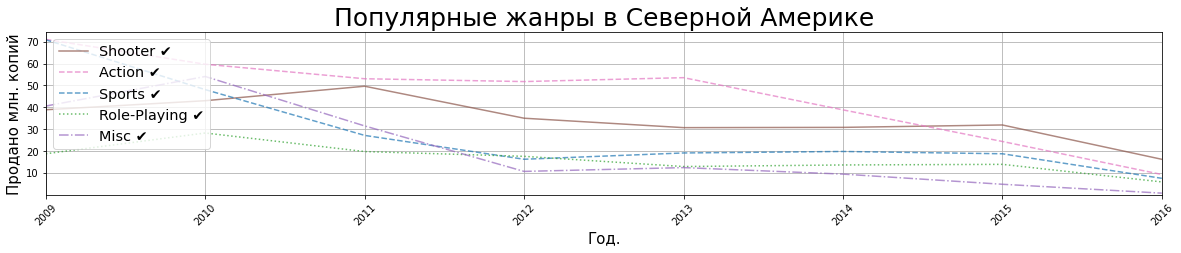

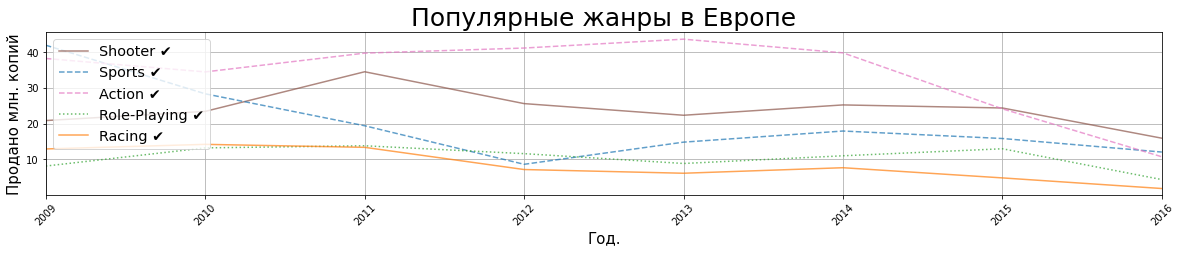

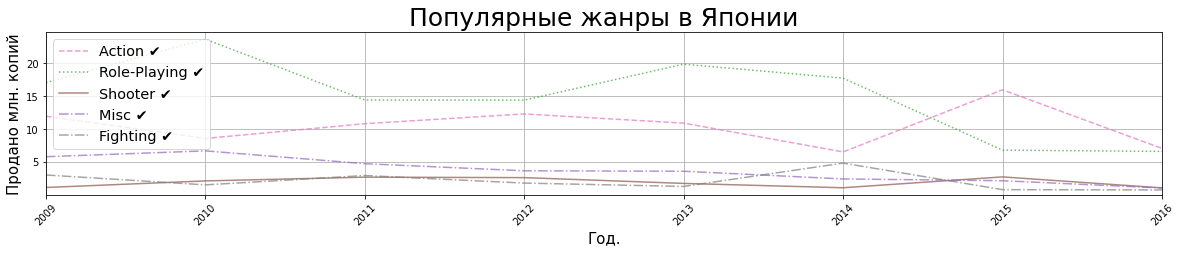

In [45]:
top_5_genre = draw_top_charts(actual_games_history, 'genre', title='Популярные жанры',curv_dic=genre_curv_dic)

In [46]:
draw_top_table(top_5_genre, title='Популярные жанры')

'Популярные жанры'

,na_genr,na_rt_3,na_last,na_all_yr,eu_genr,eu_rt_3,eu_last,eu_all_yr,jp_genr,jp_rt_3,jp_last,jp_all_yr
rate,,,,,,,,,,,,
1,Shooter,23.91,16.24,34.5,Shooter,20.28,15.90,24.0,Action,9.95,7.07,10.5
2,Action,19.25,9.29,45.2,Action,20.03,10.68,34.0,Role-Playing,8.53,6.61,15.1
3,Sports,13.33,7.54,28.5,Sports,14.26,12.01,19.9,Misc,1.64,1.04,3.8
4,Role-Playing,9.86,5.89,16.4,Role-Playing,8.28,4.28,10.4,Shooter,1.62,1.06,1.9
5,Misc,3.56,0.76,20.5,Racing,3.74,1.77,8.5,Fighting,1.44,0.75,2.1


В Европе и Америке рейтинги жанров очень похожи.

В Японии жанры практически те-же, а вот их распределение по местам уже другое

Жанр **Action** Во всех странах занимает 1 или второе место.
**Shooter** На первых местах в Европе и Америке, а вот Япония отдала ему 4 место.

В общем по трём странам самые популярные жанры **Shooter,Action**. Они будут продаваться везде.

А вот какие дополнительные жанры дадут максимальную прибыль нужно смотреть по целевой стране.

## Влияние рейтинга на продажи в разных регионах

In [47]:
#создание словаря линий для platform
rating_curv_dic = create_curv_dic(games_history,'rating')

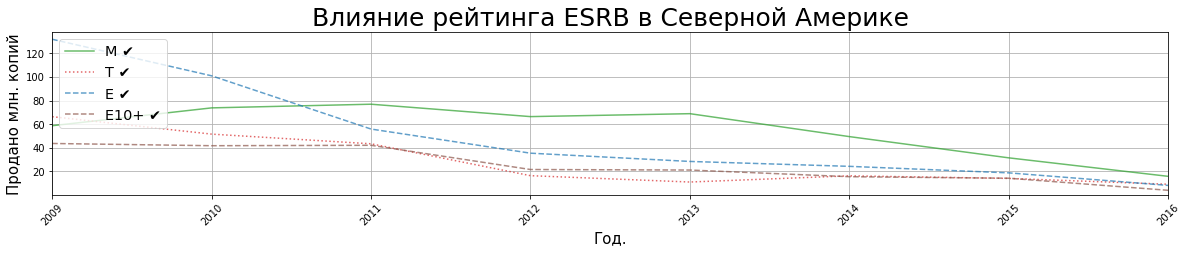

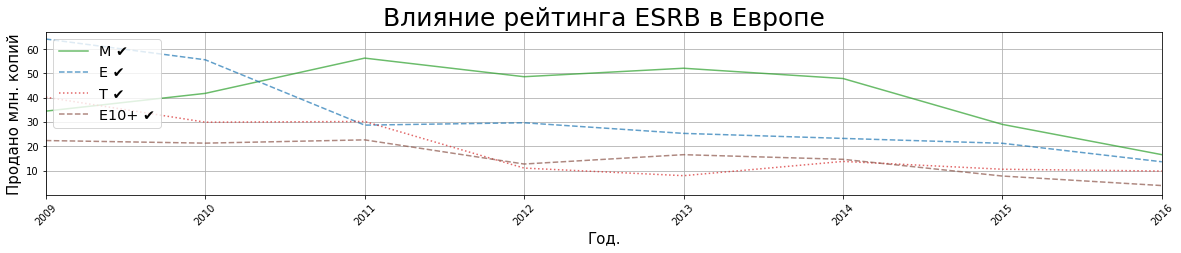

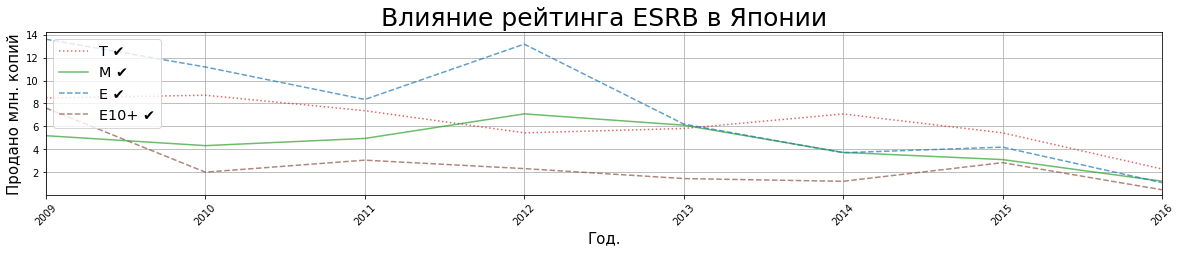

In [48]:
top_5_rating = draw_top_charts(actual_games_history.query('rating != "NR"'), 'rating', title='Влияние рейтинга ESRB'
                               , top=4, curv_dic=rating_curv_dic)

Япония опять отличилась, видно что игры с рейтингом **M** не имеют такого превосходства над другими рейтингами. 

Здесь больше в ходу рейтинг **T**. Но при этом видно, что предпочтения японцев не так давно поменялись резко поднявшейся спрос на игры **E** рейтинга опустился и уступил первенство рейтингу **T**, что не наблюдается в других странах.
В итоге, если смотреть на Японию, то на данный момент нужно делать ставку на игры с **T** рейтингом. 

Но опять же, судя по последним тенденциям разница между рейтингами сокращается.

# Вывод

1. Пользователь NA: Предпочтёт игру на платформе PS4 или XOne в жанре Shooter или Action с рейтингом M
2. Пользователь EU: Предпочтет игру на платформе PS4 или XOne в жанре Action или Sport с рейтингом  M или E
3. Пользователь JP: Предпочтет игру на платформе 3DS или PS4 в жанре Action или Role-Playing и скорее с рейтингом T
Но здесь стоит обратить внимание, что разница в популярности одного или другого рейтинга может зависеть от популярности жанра.

Shooter и Action скорее будут иметь рейтинг M,
А вот игры жанра Sport более вероятно имеют рейтинг E, возможно это причина того, что там где игры Sport на втором месте по популярности рейтинг E так-же популярен.Ну и в японии где игры Role-Playing на втором месте в лидеры входит рейтинг T который такие присущ таким играм.

# Часть 4. Проверка гипотез

In [49]:
def check_hypothesis(data_1, data_2, test, alpha=0.05, equal_var=True, h0=True, hyp0='',hyp1='', font_size=4):
    '''
    Функция для вывода результатов проверки гипотиз
    критический уровень статистической значимости 
    '''
    if test == 'ttest_ind': results = st.ttest_ind(data_1,data_2,equal_var = equal_var)
    div = ''.join(['=' for i in range(1,len(hyp0))])
    print(div)
    # если p-value окажется меньше него - отвергнем гипотезу    
    display(f'p-значение: {results.pvalue}')

    if results.pvalue < alpha:
        display(f'Нулевая гипотезу H₀ - {hyp0} ОТВЕРГНУТА!')                 
        if not h0: 
            print(div)
            display(f'НЕТ оснований отвергать альтернативную гипотезу. '
                                + f'H₁- {hyp1}')
        
    else:    
        display(f'Нет оснований отвергать нулевую гипотезу. '
                    + f'H₀ - {hyp0}')
        if not h0: 
            print(div)
            display(f'Альтернативная гипотеза H₁ -'
                                +f'{hyp0} ОТВЕРГНУТА!')                      
    print(div)

## Средние пользовательские рейтинги платформ Xbox One и PC одинаковые

Из имеющихся данных составим массивы:
1. Пользовательские оценки игр на платформе **Xbox One**
2. Пользовательские оценки игр на платформе **PC**

In [50]:
def sheck_selection(data,column_filtered,val_filtr,column,title):
    selection = actual_games_history.query(f'{column_filtered} == "{val_filtr}" and user_score > 0')
    mu, std_dev =  info_print(selection
            ,title, column=column, bins=10, prntInfo=False, prntGraph=True, returnMetric=True)
    sigma3_min = mu - 3*std_dev
    sigma3_max = mu + 3*std_dev    
    div = ''.join(['=' for i in range(1,50)])   
    result =  selection.query(f'@sigma3_min <= {column} <= @sigma3_max')[column] #Без выбросов
    disp = round(np.var(result),2)
    display(f'Дисперсия после удаления выбросов: {disp}')
    display(f'Размер выборки {len(result)}')
    print(div)
    return disp, result

def show_difference (a,b,lim):
    if a > b:
        dif =  100 * (a - b) / a       
    else:
        dif =  100 * (b - a) / b  
    display(f'Разница дисперсий: {round(dif)}%')      
    return dif < lim

Среднее: 6.52 

Стандартное отклонение: 1.38 

Доверительный интервал: от 2.39 до 10.64 



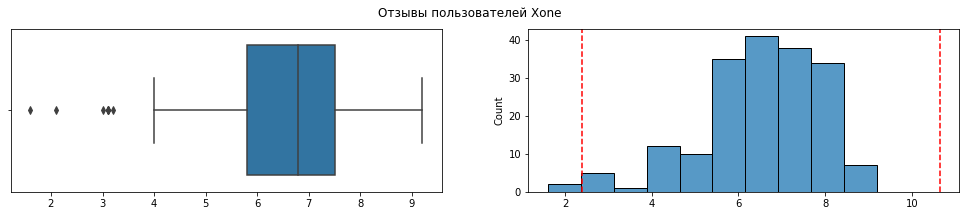

'Дисперсия после удаления выбросов: 1.67'

'Размер выборки 183'

Среднее: 6.66 

Стандартное отклонение: 1.55 

Доверительный интервал: от 2.01 до 11.31 



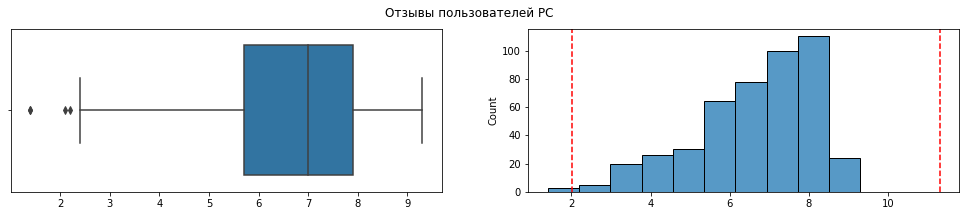

'Дисперсия после удаления выбросов: 2.29'

'Размер выборки 458'

'Разница дисперсий: 27%'

In [51]:
Xone_us_sc_disp, Xone_user_score = sheck_selection(actual_games_history
                                  ,'platform','XOne','user_score','Отзывы пользователей Xone')

PC_us_sc_disp, PC_user_score = sheck_selection(actual_games_history
                                  ,'platform','PC','user_score','Отзывы пользователей PC')
equal = show_difference(Xone_us_sc_disp, PC_us_sc_disp,5)  


Примем за генеральные совокупности все средние оценки учтенные и гипотетические всех игр всеми пользователями на платформах Xone для первой ГС и на платформе PC для второй ГС!

А срезы наших зафиксированных оценок будут выборками из генеральных совокупностей.

Средняя пользовательская оценка игры величина лимитированная, но исчислима т.к. она не ограничена форматом целых чисел и считается как среднее от всех оценок пользователей определённой игры. Значит тип данных у нас количественный.

Размеры выборок превышают 50, а значит можем считать, что выборочное среднее величины распределено нормально.

Мы сравниваем 2 выборки, следовательно, для проверки гипотезы нам подходит T-тестирование(ttest_ind).


Нам нужно подтвердить гипотезу о том, что средние пользовательские рейтинги платформ **Xbox One** и **PC** одинаковые.

Т.е. нужно проверить Гипотезу о равенстве средних двух генеральных совокупностей.

В нашей гипотезе уже используется знак равенства, а значит она и будет нулевой.

**H₀** - средние пользовательские рейтинги платформ **Xbox One** и **PC** одинаковые. (не различается).

Установим критический уровень статистической значимости в большее из общепринятых значений т.к. нас интересует более точное совпадение средних, т.е. меньшее отклонение показателя вероятности совпадения (p-values)

In [52]:
check_hypothesis(Xone_user_score, PC_user_score, test='ttest_ind', alpha=0.05, equal_var=equal, h0=True
                 , hyp0='Средние пользовательские рейтинги платформ Xbox One и PC одинаковые.')

'p-значение: 0.33714683848863103'

'Нет оснований отвергать нулевую гипотезу. H₀ - Средние пользовательские рейтинги платформ Xbox One и PC одинаковые.'

**Вывод**
Нет оснований считать, что Средние пользовательские рейтинги платформ Xbox One и PC отличаются.

Проверка гипотезы методом T-критерия Стьюдента показала, что более вероятно то, что Средние пользовательские рейтинги платформ Xbox One и PC одинаковые.

## Средние пользовательские рейтинги жанров Action и Sports разные.

Среднее: 6.77 

Стандартное отклонение: 1.36 

Доверительный интервал: от 2.71 до 10.84 



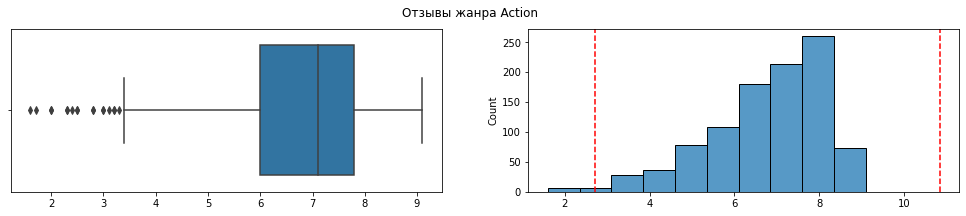

'Дисперсия после удаления выбросов: 1.65'

'Размер выборки 983'

Среднее: 6.05 

Стандартное отклонение: 1.68 

Доверительный интервал: от 1.02 до 11.08 



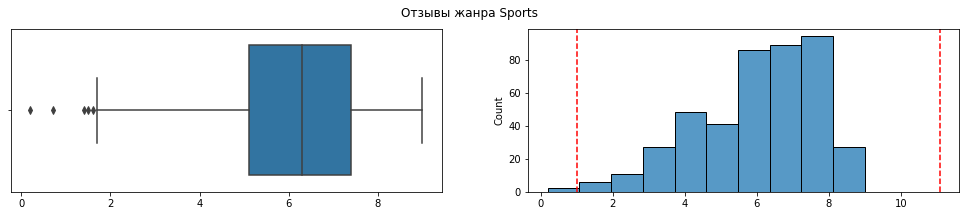

'Дисперсия после удаления выбросов: 2.67'

'Размер выборки 429'

'Разница дисперсий: 38%'

In [53]:
Action_us_sc_disp, Action_user_score = sheck_selection(actual_games_history
                                  ,'genre','Action','user_score','Отзывы жанра Action')

Sports_us_sc_disp, Sports_user_score = sheck_selection(actual_games_history
                                  ,'genre','Sports','user_score','Отзывы жанра Sports')

equal = show_difference(Action_us_sc_disp, Sports_us_sc_disp,5)  



Примем за генеральные совокупности все средние оценки учтенные и гипотетические всех игр всеми пользователями жанров Action для первой ГС и Sport для второй ГС!

А срезы наших зафиксированных оценок будут выборками из генеральных совокупностей.

Средняя пользовательская оценка игры величина лимитированная, но исчислима т.к. она не ограничена форматом целых чисел и 
считается как среднее от всех оценок пользователей определённой игры. Значит тип данных у нас количественный.

Размеры выборок превышают 50, а значит можем считать, что выборочное среднее величины распределено нормально.

Мы сравниваем 2 выборки, следовательно, для проверки гипотезы нам подходит T-тестирование(ttest_ind).

Нам нужно подтвердить гипотезу о том, что Средние пользовательские рейтинги жанров Action и Sports разные.
Т.е. нужно проверить Гипотезу о не равенстве средних двух генеральных совокупностей.
Для того, чтобы использовать знак равенства в гипотезах сформулируем нулевую гипотезу.

**H₀** - Средние пользовательские рейтинги жанров Action и Sports одинаковы (не различается).

Исходя из **H₀** сформулируем альтернативную гипотезу **H₁**. 
Для этой **H₀** она будет соответствовать гипотезе поставленной задачи.

**H₁** - Средние пользовательские рейтинги жанров Action и Sports разные.

Установим критический уровень статистической значимости в меньшее из общепринятых значений т.к. нас интересует 
значительное расхождение в рейтингах.

In [54]:
check_hypothesis(Action_user_score, Sports_user_score, test='ttest_ind', alpha=0.01, equal_var=equal, h0=False
                 , hyp0='Средние пользовательские рейтинги жанров Action и Sports одинаковы.'
                 , hyp1='Средние пользовательские рейтинги жанров Action и Sports разные.')

'p-значение: 5.263186932286041e-16'

'Нулевая гипотезу H₀ - Средние пользовательские рейтинги жанров Action и Sports одинаковы. ОТВЕРГНУТА!'

'НЕТ оснований отвергать альтернативную гипотезу. H₁- Средние пользовательские рейтинги жанров Action и Sports разные.'

**Вывод**

Гипотеза о том, чир Средние пользовательские рейтинги жанров Action и Sports разные. Не отвергнута.

Вероятность того, что средняя выручка двух жанров совпадет ничтожно мала.
0,5 * 10<sup>-15</sup>

# Общий вывод

На рынке существуют несколько лидеров в различных категориях и эти лидеры меняются в зависимости от времени и места.

На данный момент 2016 г. лидерами являются платформы:

**Play Station 4** и **XBOX ONE** в **Европе** и **США** и **Nintendo 3DS** и **Play Station 4** в **Японии**

Пользователи в США предпочитают Стрелялки и Экшены, в Европе Стрелялки и Спортивные игры, а в Японии  